In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from colors import strip_color
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
import array
import math
from scipy.stats import norm

sns.set_style("whitegrid")

In [2]:
LOG_PATH = Path('/Users/rhan0013/Google Drive/My Drive/RandChain/log/')

In [3]:
def get_files(blocktime, num_nodes, num_miners, long=False):
    log_folder = '%d_%d_%d' % (blocktime, num_nodes, num_miners)
    if long == True:
        log_folder += '_long'
    data_path = LOG_PATH / log_folder
    log_files = [x for x in data_path.iterdir() if x.name.endswith('.log')]
    dstat_files = [x for x in data_path.iterdir() if x.name.endswith('.csv')]
    return log_files, dstat_files

In [4]:
def _sanitize(s):
    s = strip_color(s)
    s = s.strip('[1;38;5;8m')
    s = s.strip('\n')
    return s

def _get_time(s):
    dt_str = s[0:19]
    return datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')

# Thanks god this post saves my life https://stackoverflow.com/a/56924458/4725426
def _reverse_hex(hex_string):
    if isinstance(hex_string, str):
        input_is_string = True
        hex_string = hex_string.encode()
    a = array.array('H', hex_string)
    a.reverse()
    output = a.tobytes()
    if input_is_string:
        return output.decode()
    else:
        return output

def get_blocks(log_file):
    blocks_mined = dict()
    blocks_received = dict()
    for line in open(log_file.absolute()):
        line = _sanitize(line)
        if line.find('mined by') != -1:
            miner = line.split(' ')[-1].strip('!')
            block = line.split(' mined by ')[0].split(' ')[-1]
            blocks_mined[block] = {'miner': miner, 'time': _get_time(line)}
        if line.find(' verification finished') != -1:
            block = line.split(' verification finished')[0].split(' ')[-1]
            if block not in blocks_received.keys():
                blocks_received[block] = {'time': _get_time(line), 'dead-end': False}
        if line.find(' has provided dead-end block ') != -1:
            block = line.split(' has provided dead-end block ')[-1]
            if block not in blocks_received.keys():
                blocks_received[block] = {'time': _get_time(line), 'dead-end': True}
            else:
                blocks_received[block]['dead-end'] = True

    # remove blocks mined by itself
    for block in blocks_mined:
        del blocks_received[block]
    return blocks_mined, blocks_received

lfiles, dfiles = get_files(1, 32, 8)
bm, br = get_blocks(lfiles[0])
# bm, br

## Block propagation delay

- Definition: how long it takes for a block to be propagated to the entire network?
- Example: [OHIE paper](https://arxiv.org/pdf/1811.12628.pdf) Section 6A/6B
- Method: Collect when nodes receive the block, calculate time difference
- Expected result: much better than other protocols

Let's refer to NC-Max Figure 6 as example https://eprint.iacr.org/2020/1101.pdf

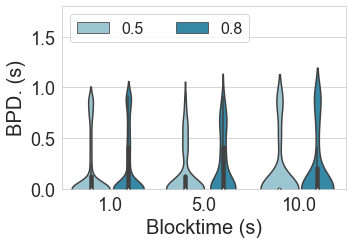

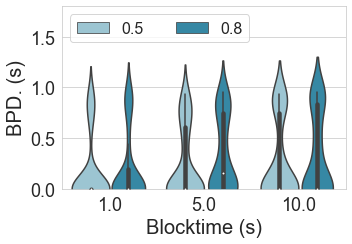

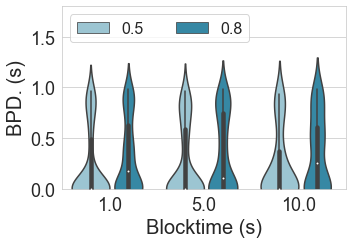

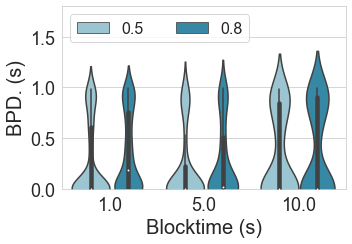

In [25]:
def get_bpd(blocktime, num_nodes, num_miners):
    # dict{block: [gap1, gap2, ...]}
    times_dict = dict()
    lfiles, _ = get_files(blocktime, num_nodes, num_miners)
    for lf in lfiles:
        blocks_mined, blocks_received = get_blocks(lf)
        for block, data in blocks_mined.items():
            if block in times_dict.keys():
                times_dict[block].append(data['time'])
            else:
                times_dict[block] = [data['time']]
        for block, data in blocks_received.items():
            if block in times_dict.keys():
                times_dict[block].append(data['time'])
            else:
                times_dict[block] = [data['time']]
    
    for block, times in times_dict.items():
        oldest_time = min(times)
        deltas = [(t - oldest_time) for t in times]
        times_dict[block] = deltas
    
    return times_dict

def plot_bpd():
    ns = [128, 256, 512, 1024]
    for n in ns:
        plt.figure(0, figsize=(5, 3.5))
        df = pd.DataFrame(columns=['Blocktime', 'Number of nodes', 'Percentage', 'Block propagation delay'])
        for bt in [1, 5, 10]:
            deltas_dict = get_bpd(bt, n/8, 8)
#             for perc in [0.5, 0.9]:
            delays_05 = [np.sort(np.array(t))[0:int(n/8*0.5)].mean() for _, t in deltas_dict.items() if len(t) > n/8*0.8]
            for delay in delays_05:
                delay_s = np.float64(delay.microseconds) / 1000000
                s = pd.Series(data=[bt, n/8, 0.5, delay_s], index=['Blocktime', 'Number of nodes', 'Percentage', 'Block propagation delay'])
                df = df.append(s, ignore_index=True)
            
            delays_09 = [np.sort(np.array(t))[0:int(n/8*0.8)].mean() for _, t in deltas_dict.items() if len(t) > n/8*0.8]
            for delay in delays_09:
                delay_s = np.float64(delay.microseconds) / 1000000
                s = pd.Series(data=[bt, n/8, 0.8, delay_s], index=['Blocktime', 'Number of nodes', 'Percentage', 'Block propagation delay'])
                df = df.append(s, ignore_index=True)
                
        ax = sns.violinplot(
            x="Blocktime", 
            y="Block propagation delay", 
            palette=sns.color_palette('ocean_r'),
            hue="Percentage", 
#             split=True, 
            data=df
        )
        
        # for i, violin in enumerate(ax.findobj(mpl.collections.PolyCollection)):
        #     if i % 2:
        #         violin.set_hatch("//")
        #     else:
        #         violin.set_hatch('++')

        ax.set_ylim([0, 1.8])
        ax.set_xlabel('Blocktime (s)',fontsize=20)
        ax.set_ylabel('BPD. (s)',fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=18)
        
        ax.legend(ncol=2, loc='upper left', fontsize=16)
        # ax.legend_.findobj(mpl.patches.Rectangle)[1].set_hatch("//")
        # ax.legend_.findobj(mpl.patches.Rectangle)[0].set_hatch("++")

        plt.tight_layout()
        plt.savefig('../../randchain-paper/paper/figs/bpd-%d.pdf' % n)
        plt.show()
        plt.close()

# deltas_dict = get_bpd(1, 128, 8)
# [np.array(t).mean() for _, t in deltas_dict.items() if len(t) > 128*0.9]
# deltas_dict
# ' '.join([str(len(deltas_dict[block])) for block in deltas_dict])
plot_bpd()

## Decentralisation factor

- How many different miners are generating blocks?
- Blocktime v.s. decentralisation factor

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


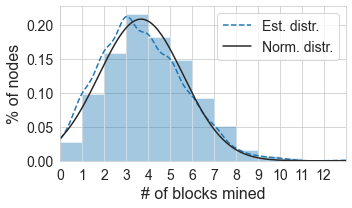

In [6]:
def get_dec_fac(blocktime, num_nodes, num_miners, long=False):
    # dict{block: [gap1, gap2, ...]}
    miners_dict = dict()
    lfiles, _ = get_files(blocktime, num_nodes, num_miners, long)
    for lf in lfiles:
        blocks_mined, blocks_received = get_blocks(lf)
        for block, blkdata in blocks_mined.items():
            if block in blocks_received.keys() and ('dead-end' not in blocks_received[block].keys() or blocks_received[block]['dead-end'] == True):
                continue
            miner = blkdata['miner']
            if miner in miners_dict.keys():
                miners_dict[miner] += 1
            else:
                miners_dict[miner] = 1
    
    return miners_dict

def plot_dec():
    miners_dict = get_dec_fac(1, 128, 8, True)
    miner_values = list(miners_dict.values())
    zero_miners = [0] * (1024 - len(miner_values))
    miner_values += zero_miners
    
    plt.figure(0, figsize=(5, 3))
    ax = sns.distplot(miner_values, bins=13, fit=norm, kde_kws={"ls": "dashed"})
    ax.set_xlim([0, 13])
    ax.set_xlabel('# of blocks mined',fontsize=16)
    ax.set_ylabel('% of nodes',fontsize=16)
    ax.set_xticks(np.arange(0, 13))
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(labels=['Est. distr.','Norm. distr.'], fontsize=14)
    plt.tight_layout()
    plt.savefig('../../randchain-paper/paper/figs/dec-fac.pdf')
    plt.show()

plot_dec()

## Network bandwidth utilisation

- Definition: average used bandwidth per node
- Example: [HydRand paper](https://eprint.iacr.org/2018/319.pdf) Appendix A
- Method: On every node, run `dstat`
- Expected result: much better than other protocols

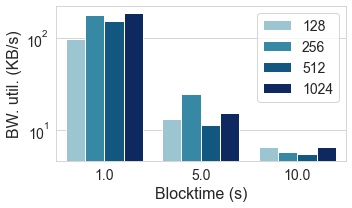

In [7]:
def get_bw_util(blocktime, num_nodes, num_miners):
    _, dfiles = get_files(blocktime, num_nodes, num_miners)
    recvs, sends = [], []
    for dfile in dfiles:
        df = pd.read_csv(dfile.absolute(), skiprows=6)
        recvs.append(df['recv'].mean())
        sends.append(df['send'].mean())
    return np.array(recvs).mean(), np.array(sends).mean() # all in Bytes

get_bw_util(10, 128, 8)

def plot_bw_util_both():
    blocktimes = [1, 5, 10]
    
    nodes = np.array([128, 256, 512, 1024])
    
    plt.figure(0, figsize=(6, 4))
    df = pd.DataFrame(columns=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
    for bt in blocktimes:
        for n in nodes:
            bw_series = pd.Series(data=[bt, n, get_bw_util(bt, n/8, 8)[0] / 1000], index=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
            df = df.append(bw_series, ignore_index=True)
    
    ax = sns.barplot(x="Blocktime", y="Bandwidth utilisation", hue="Number of nodes", data=df)
    ax.set(yscale="log")
    ax.set_xlabel('Blocktime (s)',fontsize=20)
    ax.set_ylabel('Used BW. (KB/s)',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    leg = plt.legend(ncol=2, fontsize=16)
    for t in leg.texts:
        t.set_text('%d' % float(t.get_text()))

    plt.tight_layout()
    plt.savefig('../../randchain-paper/paper/figs/bw-util-in.pdf')
    plt.show()
    plt.close()
    
    plt.figure(0, figsize=(6, 4))
    df = pd.DataFrame(columns=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
    for bt in blocktimes:
        for n in nodes:
            bw_series = pd.Series(data=[bt, n, get_bw_util(bt, n/8, 8)[1] / 1000], index=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
            df = df.append(bw_series, ignore_index=True)
    
    ax = sns.barplot(x="Blocktime", y="Bandwidth utilisation", hue="Number of nodes", data=df)
    ax.set(yscale="log")
    ax.set_xlabel('Blocktime (s)',fontsize=20)
    ax.set_ylabel('Used BW. (KB/s)',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    leg = plt.legend(ncol=2, fontsize=16)
    for t in leg.texts:
        t.set_text('%d' % float(t.get_text()))

    plt.tight_layout()
    plt.savefig('../../randchain-paper/paper/figs/bw-util-out.pdf')
    plt.show()
    plt.close()
    
def plot_bw_util():
    blocktimes = [1, 5, 10]
    nodes = np.array([128, 256, 512, 1024])
    
    plt.figure(0, figsize=(5, 3))
    df = pd.DataFrame(columns=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
    for bt in blocktimes:
        for n in nodes:
            bws = get_bw_util(bt, n/8, 8)
            total_bw = bws[0] + bws[1]
            bw_series = pd.Series(data=[bt, n, total_bw / 1000], index=['Blocktime', 'Number of nodes', 'Bandwidth utilisation'])
            df = df.append(bw_series, ignore_index=True)
    
    ax = sns.barplot(x="Blocktime", y="Bandwidth utilisation", hue="Number of nodes", data=df, palette=sns.color_palette('ocean_r'))
    
    # hatches = ['xx', '++', '//', '\\\\']
    # for i, thisbar in enumerate(ax.patches):
    #     thisbar.set_hatch(hatches[int(np.floor(i/3))])
    
    ax.set(yscale="log")
    ax.set_xlabel('Blocktime (s)',fontsize=16)
    ax.set_ylabel('BW. util. (KB/s)',fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    leg = plt.legend(ncol=1, fontsize=14)
    for t in leg.texts:
        t.set_text('%d' % float(t.get_text()))

    plt.tight_layout()
    plt.savefig('../../randchain-paper/paper/figs/bw-util.pdf')
    plt.show()
    plt.close()

plot_bw_util()